# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn import datasets, metrics, model_selection


#  Reading data

In [3]:
xlsx = pd.ExcelFile('./Data/Outliers_out.xlsx')
df = pd.read_excel(xlsx, '1x 5s')
dataset= df.copy()

#  Exploring the data

In [4]:
dataset.head()
dataset.tail()

,DEPTH,SP,RHOB,NPHI,ILD,GR
4953,2054.3520,76.1875,2.252,0.2686,3.0955,64.3568
4954,2054.5044,76.1875,2.276,0.2686,3.1877,65.8693
4955,2054.6568,76.1875,2.326,0.2671,3.2799,67.3818
4956,2054.8092,76.3724,2.354,0.2759,3.3557,68.8871
4957,2054.9616,76.5731,2.356,0.2642,3.4302,70.3918


In [5]:
column_names = ['DEPTH', 'SP', 'RHOB', 'NPHI','ILD','GR']

In [6]:
dataset.describe()

,DEPTH,SP,RHOB,NPHI,ILD,GR
count,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000
mean,1671.529747,80.460291,2.223081,0.435640,5.829968,36.159651
std,222.049495,7.590529,0.218437,0.138693,10.350587,8.808237
min,1284.122400,67.884400,1.060000,0.053700,0.564300,14.605700
25%,1481.061300,74.472150,2.156500,0.295900,2.097625,29.862700
50%,1671.599400,79.268350,2.260000,0.482400,2.626900,34.764300
75%,1865.337900,84.794450,2.368000,0.537100,3.916050,40.922475
max,2054.961600,106.062500,2.720000,0.771500,175.064500,73.442600


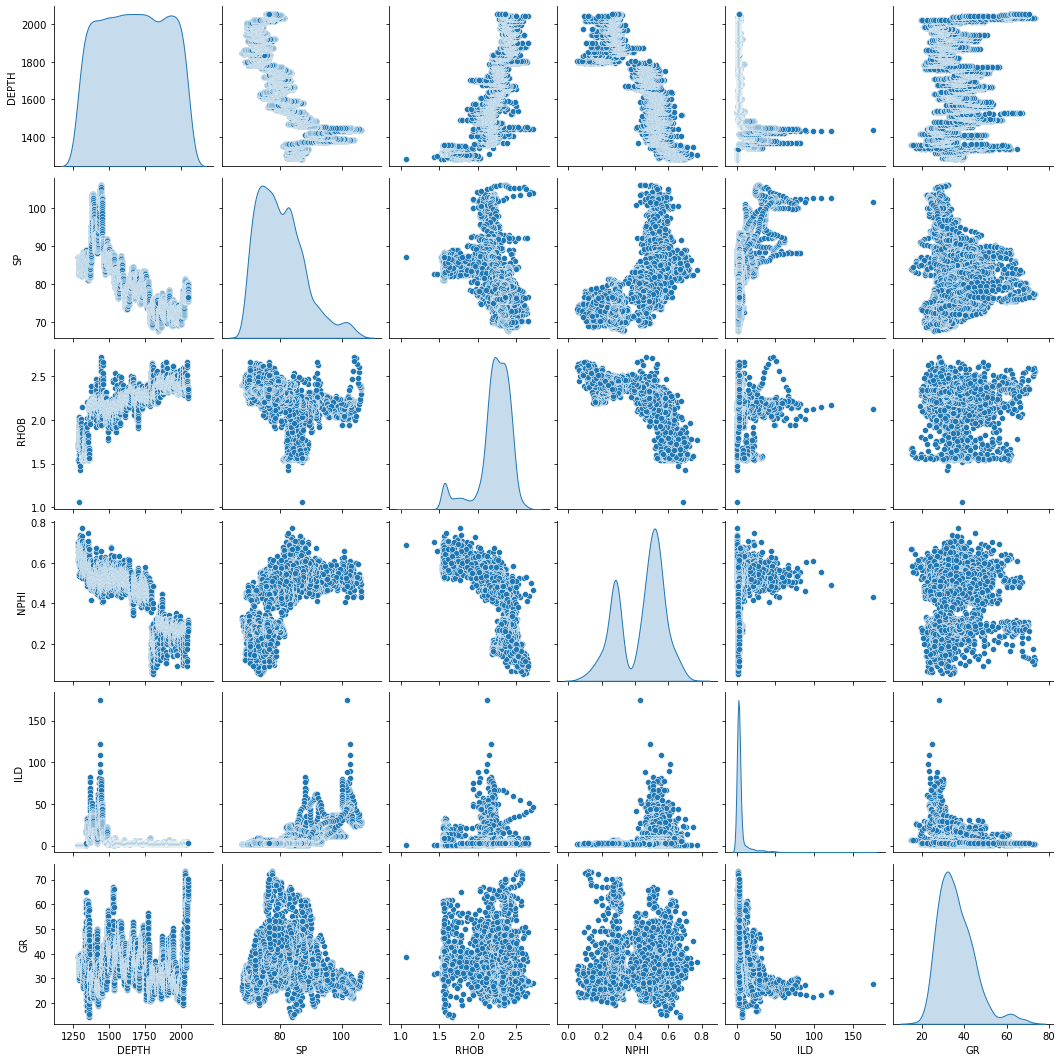

In [7]:
sns.pairplot(dataset[column_names], diag_kind='kde')

### Clean the data

In [8]:
# If the dataset contains a few unknown values.

dataset.isna().sum()

#if so Drop those rows to keep this initial tutorial simple.

dataset = dataset.dropna()

#then confirm drop
dataset.isna().sum()

# help(dataset.sample)

DEPTH    0
SP       0
RHOB     0
NPHI     0
ILD      0
GR       0
dtype: int64

In [9]:
#### Split the data into train and test

In [10]:
# the 'sample' method takes a certain fraction randomly
#Note that we use `random_state` to ensure the reproducibility of the examples.
train_dataset = dataset.sample(frac=0.7, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

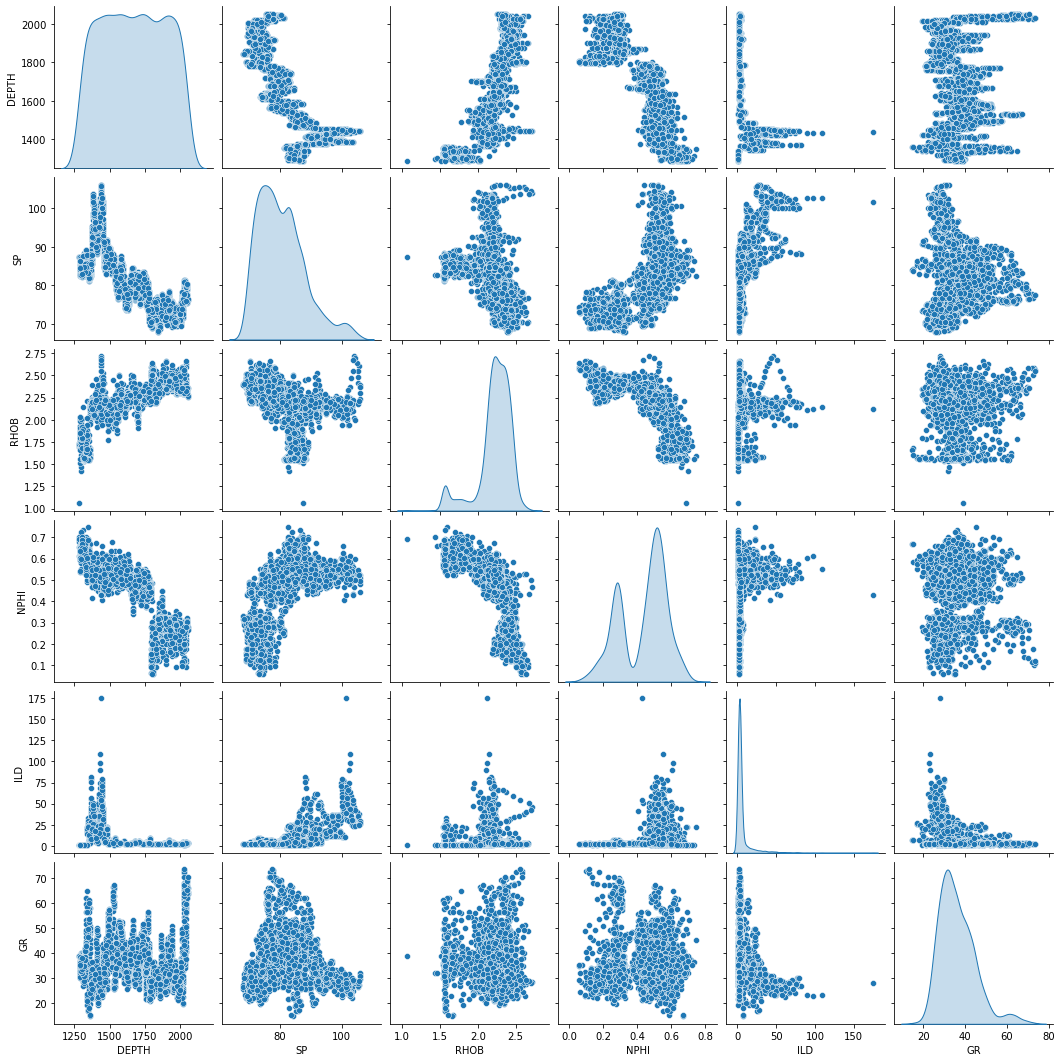

In [11]:
# Inspect the data
# Have a quick look at the joint distribution of a few pairs of columns from the training set.
# (   ) is a function of all the other parameters. Looking at the other rows it should be clear that they are functions of each other

sns.pairplot(train_dataset[column_names], diag_kind='kde')

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DEPTH,3471.0,1669.686629,222.110993,1284.2748,1479.34680,1669.5420,1863.47100,2054.9616
SP,3471.0,80.522702,7.647740,67.8844,74.54185,79.2646,84.84455,106.0625
RHOB,3471.0,2.222204,0.218266,1.0600,2.15600,2.2580,2.36400,2.7200
NPHI,3471.0,0.436384,0.137932,0.0566,0.29790,0.4834,0.53760,0.7490
ILD,3471.0,5.920798,10.589117,0.5643,2.09885,2.6203,3.90730,175.0645
GR,3471.0,36.177188,8.811776,14.6057,29.86290,34.7130,41.05985,73.4426


##### Splitting the train and test data into input and target

In [13]:

# split datat into input and target

train_input = train_dataset.copy()
test_input = test_dataset.copy()

train_target = train_input.pop('RHOB')
test_target = test_input.pop('RHOB')



In [14]:

train_input.head()
# type(train_input)

,DEPTH,SP,NPHI,ILD,GR
933,1431.0360,99.3533,0.5659,26.4863,23.6097
3691,1861.2612,70.0695,0.3042,1.7244,30.0409
2730,1709.9280,77.9375,0.4263,3.5973,28.8262
142,1306.0680,82.7469,0.6216,0.6879,37.5992
3294,1795.8816,73.9070,0.1362,2.0932,27.7350


# A DNN regression¶
These models will contain a few more layers than the linear model:

###     1. The normalization layer.
###    2. Two hidden, nonlinear, Dense layers using the relu nonlinearity.
###    3. A linear single-output layer.

### normalization
The normalisation layer
Normalization layer is a clean and simple way to build that preprocessing into your mode

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
DEPTH,1669.686629,222.110993
SP,80.522702,7.647740
RHOB,2.222204,0.218266
NPHI,0.436384,0.137932
ILD,5.920798,10.589117
GR,36.177188,8.811776


In [16]:
normalizer = preprocessing.Normalization()

#then adapt it to the data
normalizer.adapt(np.array(train_input))

# This calculates the mean and variance, and stores them in the layer.
print(normalizer.mean.numpy())

[1.6696866e+03 8.0522705e+01 4.3638378e-01 5.9207983e+00 3.6177189e+01]


In [17]:
# When the layer is called it returns the input data, with each feature independently normalized:

first = np.array(train_input[:2])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[1431.04   99.35    0.57   26.49   23.61]
 [1861.26   70.07    0.3     1.72   30.04]]

Normalized: [[-1.07  2.46  0.94  1.94 -1.43]
 [ 0.86 -1.37 -0.96 -0.4  -0.7 ]]


In [18]:
# A function to hold preprocessor, layers, model and compiler 
def FFBackProp(inputs, output):
    #normalization
    normalizer=preprocessing.Normalization()
    #then adapt it to the data
    normalizer.adapt(np.array(inputs))
    
    
    #  Create layers
    l0=normalizer
    #Dense layers using the relu nonlinearity. #with an l2 regularization to reduce overfitting by reducing weight size
    l1=tf.keras.layers.Dense(64,activation="relu", input_shape=(5,), kernel_regularizer="l2")
    
    layers.Dropout(0.1), #a droput layer # an attempt to reduce overfitting
    
    l2=tf.keras.layers.Dense(64,activation="relu", kernel_regularizer="l2")
    
    layers.Dropout(0.1),
    
    #A linear output layer
    l3=tf.keras.layers.Dense(1)
    
    
#     create the model with the layers formed
    model1 =tf.keras.models.Sequential([l0,l1,l2,l3])
    
    
#     compile the model
    model1.compile(optimizer='adam',
                loss='mean_absolute_error', #(from_logits=True),
                metrics=["mse"]
               )
    
    model1.summary()
    
    return model1
    
myFFBP= FFBackProp(train_input,train_target)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


### Train the model

In [19]:
%%time
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)

myFFBPtraining = myFFBP.fit(
    train_input, train_target,
    # Calculate validation results on 30% of the training data
    validation_split=0.3,
     # suppress logging
    verbose=0,
    epochs=100,
    

    #early stopping
    #an attempt to prevent overfitting
    #the fuction to stop the trianing by tracking the validation loss
    callbacks= keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
    
    #to store callbacks in logs
#     callbacks =[tb_callback]
)

Wall time: 11.7 s


In [20]:
# dir(myFFBPtraining.history{'loss'})
# help(tf.keras.losses.Loss)



# tensorboard dev upload --logdir \
#     'logs/fit'


# # Clear any logs from previous runs
# rm -rf ./logs/

# Load the TensorBoard notebook extension
# %load_ext tensorboard
# %tensorboard --logdir logs/



hist = pd.DataFrame(myFFBPtraining.history)
hist['epoch'] = myFFBPtraining.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
39,0.080416,0.010271,0.080598,0.009788,39
40,0.078906,0.009560,0.080759,0.010071,40
41,0.078870,0.009695,0.085572,0.010490,41
42,0.080302,0.010085,0.081978,0.010490,42
43,0.079233,0.009630,0.078723,0.009646,43


In [21]:
# Evaluate

### with visualization

In [22]:
# collect the results in a set
test_results={}
# test_results['FFBP']

test_mse, test_mae= myFFBP.evaluate(test_input, test_target, verbose=0, )
print('Test loss (mse):', test_mse)
print('Test mae:', test_mae)

Test loss (mse): 0.07861289381980896
Test mae: 0.00979017186909914


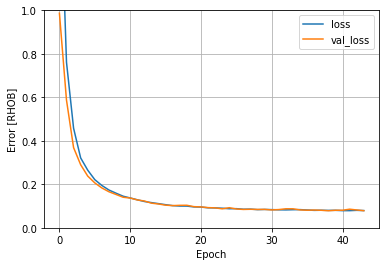

In [23]:
# a function to plot loss 
def plot_loss(arg):
  plt.plot(arg.history['loss'], label='loss')
  plt.plot(arg.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [RHOB]')
  plt.legend()
  plt.grid(True)


plot_loss(myFFBPtraining)

In [45]:
#Prediction and actual target during training

train_target_actual =train_target
train_target_predicted = myFFBP.predict(train_input)

def plotScatter(x, y):
    plt.plot(x, train_input['DEPTH'],'.-',  label='actual')
    plt.scatter( y,  train_input['DEPTH'], '.-' label='Predicted')
    plt.xlabel('RHOB')
    plt.ylabel('DEPTH')
    plt.legend()



plotScatter(train_target_actual,train_target_predicted)


SyntaxError: invalid syntax (<ipython-input-45-f1db659e7e5d>, line 8)

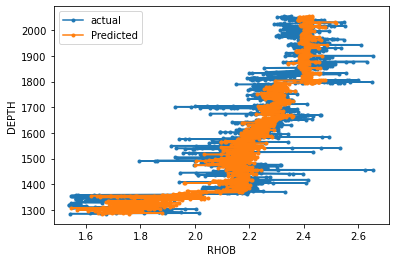

In [44]:
# A function to plot the predicted and actual target against a similar DEPTH using the test data(at validation)


test_target_actual=test_target

test_target_predicted = myFFBP.predict(test_input).flatten() ##Flattening converts multidimensional lists into one-dimensional lists


def plot_Scatter(target1, test_predict):
    plt.plot(target1, test_input['DEPTH'],'.-' , label='actual')
    plt.plot( test_predict,  test_input['DEPTH'],'.-', label='Predicted')
    plt.xlabel('RHOB')
    plt.ylabel('DEPTH')
    plt.legend()



plot_Scatter(test_target_actual,test_target_predicted)

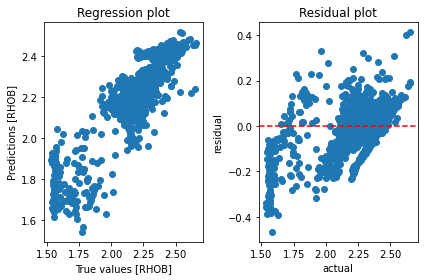

In [26]:
# Plot regression between predicted and actual (Validation)
# test_predictions = dnn_model.predict(test_input).flatten()
def plot_regression(true,predicted):
    a = plt.axes(aspect='equal')
    plt.scatter(true, predicted)
    plt.xlabel('True Values [RHOB]')
    plt.ylabel('Predictions [RHOB]')
#     lims = [1, 3]
    lims =[min(predicted)-0.3,max(true)+0.3]
    plt.xlim(lims)
    plt.ylim(lims)
# #     _ = plt.plot(lims, lims)
    x=true
    m, b = np.polyfit(true, predicted, 1) #m=slope b=intercept
    plt.plot(x, m*x + b) #add line of bestfit
    print("slope of best fit is", m)


# plot_regression(test_target_actual,test_target_predicted)


# a = plt.axes(aspect='equal')
# plt.scatter(test_target, test_prediction)
# plt.xlabel('True Values [RHOB]')
# plt.ylabel('Predictions [RHOB]')
# lims = [1, 3]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

def plot_regre_resid(true, predicted):
    fig, (ax1,ax2)=plt.subplots(1,2)
    ax1.scatter(true, predicted)
    ax1.set_xlabel('True values [RHOB]')
    ax1.set_ylabel('Predictions [RHOB]')
    ax1.set_title("Regression plot")
#     _ = ax1.plot([0, true.max()], [0, true.max()], ls='-', color='red')


    residual = true - predicted
    ax2.scatter(true, residual)
    ax2.set_xlabel('actual')
    ax2.set_ylabel('residual')
    ax2.set_title("Residual plot")
    _ = plt.axhline(0, color='red', ls='--')
    

    
    plt.tight_layout()
    plt.show
    
    
    

test_target_actual=test_target

test_target_predicted = myFFBP.predict(test_input).flatten()
plot_regre_resid(test_target_actual,test_target_predicted)

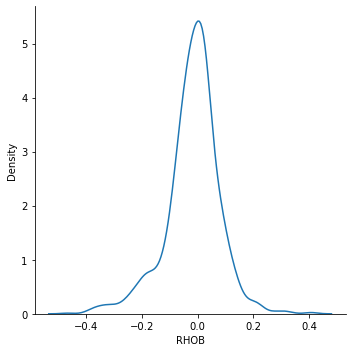

In [27]:

def plot_residual_KDE(true, predicted):
    residual = true - predicted
    _ = sns.displot(residual, kind="kde");
    
    
plot_residual_KDE(test_target_actual,test_target_predicted)

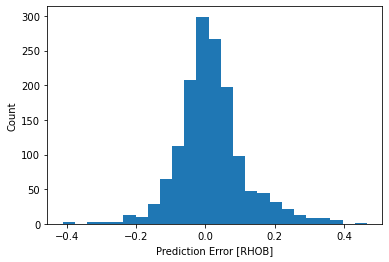

In [28]:
# Now take a look at the error distribution:

error = test_target_predicted - test_target_actual
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [RHOB]')
_ = plt.ylabel('Count')


In [29]:
#MAE

# MSE

print("from tf mae is", float(tf.keras.losses.MAE(
    test_target_actual,test_target_predicted
)))
print("from tf mae is",float(tf.keras.losses.MSE(
    test_target_actual,test_target_predicted
) ))

from tf mae is 0.06992676854133606
from tf mae is 0.00979017186909914


In [30]:
# using sklearn
print("r2 score: {}".format(metrics.r2_score(test_target_actual, test_target_predicted)))
print("mse: {}".format(metrics.mean_squared_error(test_target_actual, test_target_predicted)))
print("rmse: {}".format(np.sqrt(metrics.mean_squared_error(test_target_actual, test_target_predicted))))
print("mae: {}".format(metrics.mean_absolute_error(test_target_actual, test_target_predicted)))

r2 score: 0.7955399622271266
mse: 0.009790172187934749
rmse: 0.09894529896834285
mae: 0.06992676669828189


In [31]:

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 20124.

# Testing model on different wells


In [32]:
# read different sheet from same excel book
xlsx = pd.ExcelFile('./Data/Outliers_out.xlsx')
df = pd.read_excel(xlsx, '1x 4s')
dataset4s= df.copy()

In [33]:
# Split new data into input and target based on the training given the model

trial4s_input= dataset4s.copy() 
trial4s_target=trial4s_input.pop('RHOB')

trial4s_input.head()
trial4s_target.head()

0    1.7092
1    1.7035
2    1.6942
3    1.6868
4    1.6838
Name: RHOB, dtype: float64

In [34]:
# test new data with model

myFFBP.evaluate(trial4s_input,trial4s_target, verbose=0)
# help(myFFBP.evaluate)


[0.15330252051353455, 0.03409142419695854]

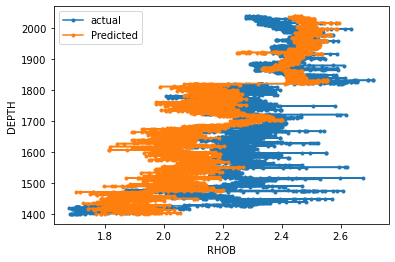

In [43]:
# A function to plot scatter
#where i try to compare the predicted and the actual target against the DEPTH

x=trial4s_target
prediction4s = myFFBP.predict(trial4s_input)

def plot_Scatter4s(target4s, predict4s):
    
    plt.plot(target4s, trial4s_input['DEPTH'],'.-',  label='actual')
    plt.plot( predict4s, trial4s_input['DEPTH'],'.-', label='Predicted')
    plt.xlabel('RHOB')
    plt.ylabel('DEPTH')
    plt.legend()



plot_Scatter4s(trial4s_target,prediction4s)

In [36]:
def plot_Regression4s(target4s, predict4s):
    
    plt.plot(target4s, predict4s, "o") #create the scatter plot
    m, b = np.polyfit(target4s, predict4s, 1) #m=slope b=intercept
    plt.plot(x, m*x + b) #add line of bestfit
    print("slope is" , np.array(b))
    
    
# plot_Regression4s(trial4s_target,prediction4s)    


slope of best fit is [0.96565378]


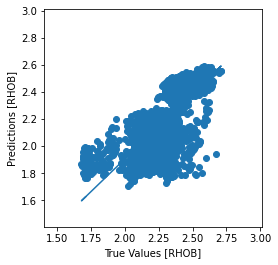

In [37]:
plot_regression(trial4s_target,prediction4s)

In [38]:
help(np.polyfit)


Help on function polyfit in module numpy:

polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
    Least squares polynomial fit.
    
    Fit a polynomial ``p(x) = p[0] * x**deg + ... + p[deg]`` of degree `deg`
    to points `(x, y)`. Returns a vector of coefficients `p` that minimises
    the squared error in the order `deg`, `deg-1`, ... `0`.
    
    The `Polynomial.fit <numpy.polynomial.polynomial.Polynomial.fit>` class
    method is recommended for new code as it is more stable numerically. See
    the documentation of the method for more information.
    
    Parameters
    ----------
    x : array_like, shape (M,)
        x-coordinates of the M sample points ``(x[i], y[i])``.
    y : array_like, shape (M,) or (M, K)
        y-coordinates of the sample points. Several data sets of sample
        points sharing the same x-coordinates can be fitted at once by
        passing in a 2D-array that contains one dataset per column.
    deg : int
        Degree of the fitting po

In [39]:

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 27064), started 0:00:44 ago. (Use '!kill 27064' to kill it.)

In [47]:
rm -rf logs

SyntaxError: invalid syntax (<ipython-input-47-b02d39b73c0e>, line 1)